In [1]:
import os
import cv2
import torch
import numpy as np
import seaborn as sn
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms

from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

%matplotlib inline

In [2]:
classes = ['Archery', 'Basketball', 'Biking', 'Billiards', 'Bowling', 'BreastStroke', 'Hammering', 'IceDancing', 'Kayaking', 'Skiing']

In [3]:
class VideoDataset(Dataset):
    def __init__(self, root_dir, transforms=transforms):
        categories = os.listdir(root_dir)
        
        self.labels = []
        self.videos = []
        
        for category in categories:
            video_path = os.path.join(root_dir, category)
            
            videos = os.listdir(video_path)
            for video in videos:
                self.videos.append(os.path.join(video_path, video))
                self.labels.append(classes.index(category))
        
        self.transforms = transforms

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        label = self.labels[idx]
        video = self.videos[idx]
        
        frames = np.zeros((16, 3, 112, 112))
        
        i = 0
        frame_names = os.listdir(video)
        for frame_name in frame_names:
            img = Image.open(os.path.join(video, frame_name))
            img = img.resize((112, 112), Image.BICUBIC)
            img = self.transforms(img)
            frames[i] = img
            i += 1
        
        frames = np.transpose(frames, (1, 0, 2, 3))
        
        return frames, label

In [4]:
train_transforms = transforms.Compose([
            transforms.Resize(112, 112),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
            transforms.ToTensor(),
            transforms.Normalize((0.43216, 0.394666, 0.37645), (0.22803, 0.22145, 0.216989))
        ])
val_transforms = transforms.Compose([
            transforms.Resize(112, 112),
            transforms.ToTensor(),
            transforms.Normalize((0.43216, 0.394666, 0.37645), (0.22803, 0.22145, 0.216989))
        ])
test_transforms = transforms.Compose([
            transforms.Resize(112, 112),
            transforms.ToTensor(),
            transforms.Normalize((0.43216, 0.394666, 0.37645), (0.22803, 0.22145, 0.216989))
        ])

In [5]:
train_dataset = VideoDataset('./dataset_ucf_video_keyframe_vc/train', train_transforms)
val_dataset = VideoDataset('./dataset_ucf_video_keyframe_vc/val', val_transforms)
test_dataset = VideoDataset('./dataset_ucf_video_keyframe_vc/test', test_transforms)

In [6]:
train_loader = DataLoader(dataset=train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=20, shuffle=False)
val_loader = DataLoader(dataset=test_dataset, batch_size=20, shuffle=False)

In [7]:
model = models.video.r3d_18(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))

i = 0
for params in model.parameters():
    if i < 9:
        params.requires_grad = False
    i += 1

In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)
criteria = nn.CrossEntropyLoss()
#reduce_lr = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=1)

In [9]:
is_cpu_available = torch.cuda.is_available()

if is_cpu_available:
    model.cuda()
    criteria.cuda()

In [10]:
n_epochs = 15

losses_epoch_train = []
accuracy_epoch_train = []

losses_epoch_val = []
accuracy_epoch_val = []

writer = SummaryWriter()

model.train()

# Training loop
for epoch in range(n_epochs):
    total = 0
    epoch_loss = 0
    epoch_correct = 0
    for ix, data in enumerate(tqdm(train_loader)):
        model.zero_grad()
        
        imgs, label = data
        
        if is_cpu_available:
            imgs = imgs.float().cuda()
            label = label.cuda()
            
        # Forward pass
        outputs = model.forward(imgs)
        loss = criteria(outputs, label)

        # Prevent gradient addition
        optimizer.zero_grad()

        # Gradient calculation
        loss.backward()

        # Optimization
        optimizer.step()

        # Train loss for iter
        epoch_loss += loss.item()

        # Train accuracy for iter
        _, predictions = torch.max(outputs.data, 1)
        correct_pediction = (predictions == label).sum()

        epoch_correct += correct_pediction
        total += len(label)
        
    losses_epoch_train.append(epoch_loss / len(train_loader))
    accuracy_epoch_train.append(epoch_correct / total)

    writer.add_scalars('loss', {'train loss': epoch_loss / len(train_loader)}, epoch)
    writer.add_scalars('acc', {'train acc': epoch_correct / total}, epoch)
    
    print('Epoch: {} - Train Loss: {} - Train Accuracy: {}'.format(epoch, epoch_loss / len(train_loader), epoch_correct / total))          

    with torch.no_grad():
        model.eval()

        total = 0
        epoch_loss = 0
        epoch_correct = 0
        # Measure the performance in validation set.
        for ix, data in enumerate(tqdm(val_loader)):

            imgs, label = data
        
            if is_cpu_available:
                imgs = imgs.float().cuda()
                label = label.cuda()

            # Test forward
            outputs = model.forward(imgs)
            loss = criteria(outputs, label)

            # Test loss for iter
            epoch_loss += loss.item()

            # Train accuracy for iter
            _, predictions = torch.max(outputs.data, 1)
            correct_pediction = (predictions == label).sum()

            epoch_correct += correct_pediction
            total += len(label)
            
        losses_epoch_val.append(epoch_loss / len(val_loader))
        accuracy_epoch_val.append(epoch_correct / total)

        writer.add_scalars('loss', {'val loss': epoch_loss / len(val_loader)}, epoch)
        writer.add_scalars('acc', {'val acc': epoch_correct / total}, epoch)

        print('Epoch: {} - Val Loss: {} - Val Accuracy: {}'.format(epoch, epoch_loss / len(val_loader), epoch_correct / total))          

    model.train()
    
writer.close()

  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch: 0 - Train Loss: 1.9430057321275984 - Train Accuracy: 0.3814433217048645


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Epoch: 0 - Val Loss: 1.572990460055215 - Val Accuracy: 0.5791367292404175


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch: 1 - Train Loss: 1.119255614523985 - Train Accuracy: 0.8257732391357422


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Epoch: 1 - Val Loss: 0.9882812223264149 - Val Accuracy: 0.8669065237045288


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch: 2 - Train Loss: 0.6992014056565811 - Train Accuracy: 0.9288660287857056


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Epoch: 2 - Val Loss: 0.6399510502815247 - Val Accuracy: 0.9532374143600464


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch: 3 - Train Loss: 0.46485691988954736 - Train Accuracy: 0.9690722227096558


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Epoch: 3 - Val Loss: 0.45089512318372726 - Val Accuracy: 0.9460431933403015


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch: 4 - Train Loss: 0.3267965325895621 - Train Accuracy: 0.9824742674827576


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Epoch: 4 - Val Loss: 0.329491026699543 - Val Accuracy: 0.9640287756919861


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch: 5 - Train Loss: 0.23488236081843472 - Train Accuracy: 0.9876288771629333


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Epoch: 5 - Val Loss: 0.2658300633941378 - Val Accuracy: 0.9712230563163757


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch: 6 - Train Loss: 0.1680159372638683 - Train Accuracy: 0.9958763122558594


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Epoch: 6 - Val Loss: 0.22993246093392372 - Val Accuracy: 0.9676259160041809


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch: 7 - Train Loss: 0.14114493724642968 - Train Accuracy: 0.9927835464477539


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Epoch: 7 - Val Loss: 0.1927118024655751 - Val Accuracy: 0.9748201370239258


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch: 8 - Train Loss: 0.11685107541935784 - Train Accuracy: 0.9948453903198242


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Epoch: 8 - Val Loss: 0.1749763177441699 - Val Accuracy: 0.9784172773361206


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch: 9 - Train Loss: 0.09982050962898197 - Train Accuracy: 0.9958763122558594


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Epoch: 9 - Val Loss: 0.15697498167199747 - Val Accuracy: 0.9748201370239258


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch: 10 - Train Loss: 0.08430035640390551 - Train Accuracy: 0.9989691376686096


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Epoch: 10 - Val Loss: 0.1352449200515236 - Val Accuracy: 0.9892086386680603


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch: 11 - Train Loss: 0.07211798209012771 - Train Accuracy: 0.9958763122558594


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Epoch: 11 - Val Loss: 0.1291048043806638 - Val Accuracy: 0.9856115579605103


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch: 12 - Train Loss: 0.06892741665396156 - Train Accuracy: 0.9979381561279297


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Epoch: 12 - Val Loss: 0.11848442934985672 - Val Accuracy: 0.9856115579605103


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch: 13 - Train Loss: 0.05510264068689882 - Train Accuracy: 0.9989691376686096


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Epoch: 13 - Val Loss: 0.1164769751152822 - Val Accuracy: 0.9820144176483154


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

Epoch: 14 - Train Loss: 0.05209008524460452 - Train Accuracy: 0.9989691376686096


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:49<00:00,  3.52s/it]

Epoch: 14 - Val Loss: 0.10509809751861862 - Val Accuracy: 0.9856115579605103


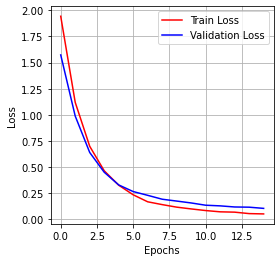

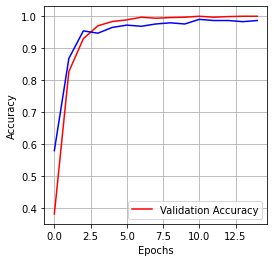

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(losses_epoch_train , color='r')
plt.plot(losses_epoch_val, color='b')
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax.grid(True)

fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(accuracy_epoch_train , color='r')
plt.plot(accuracy_epoch_val, color='b')
plt.legend(["Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
ax.grid(True)

Test Accuracy: % 0.9931034445762634 


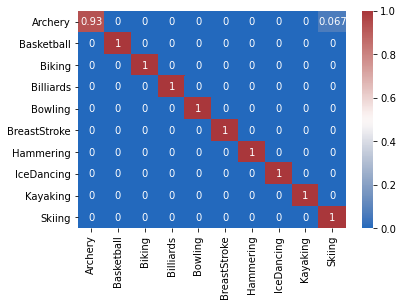

In [12]:
model.eval()

targets = []
predicts = []

with torch.no_grad():
    total = 0
    correct_prediction = 0
    for data in test_loader:
        imgs, label = data
        
        if is_cpu_available:
            img = imgs.float().cuda()
            label = label.cuda()
        
        outputs = model.forward(img)

        _, predictions = torch.max(outputs.data, 1)
        correct_prediction += (predictions == label).sum()
        
        total += len(label)
        
        preds = predictions.detach().cpu().numpy()
        labels = label.detach().cpu().numpy()
        
        for i in range(len(preds)):
            targets.append(labels[i])
            predicts.append(preds[i])

    print('Test Accuracy: % {} '.format(correct_prediction / total))
    
    matrix = confusion_matrix(targets, predicts, normalize = 'true')
    sn.heatmap(matrix, annot=True, cmap = sn.color_palette("vlag", as_cmap=True), xticklabels=classes, yticklabels=classes)